<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#План-работы" data-toc-modified-id="План-работы-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>План работы</a></span></li><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.


**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).


**Описание данных**

Данные состоят из файлов, полученных из разных источников:
* data_arc.csv — данные об электродах;
* data_bulk.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time.csv — данные о подаче сыпучих материалов (время);
* data_gas.csv — данные о продувке сплава газом;
* data_temp.csv — результаты измерения температуры;
* data_wire.csv — данные о проволочных материалах (объём);
* data_wire_time.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Подготовка

Задача сводится к тому, что нам нужно предсказывать температуру в конце цикла обработки партии, то есть последнее измерение температуры, чтобы операторы могли подать точное количество энергии на электроды. Это позволит не перегреть расплав, что сэкономит траты энергию и улучшит безопасность по эксплуатации оборудования. Обычно металлурги вынуждены подавать больше энергии и ждать, когда температура и примеси распределятся на весь объем расплава в ковше. 

К сожалению нам не доступна информацию о текущем объеме и составе вещества в ковше, это влияет на теплоемкость расплава. Если вводятся легирующие и десульфирующие вещества, то объем не может быть постоянным. Влияние этих данных не велико, но внесет небольшую ошибку и непредсказуемость. Будем считать что в начале цикла свойства расплава одинаковы.

In [1]:
# Импортирование необходимых модулей и атрибутов
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import os

from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# Создадим вспомогательные переменные, константы
SEED = 12345

In [3]:
# Объявим функцию, которая будет читать файлы
def pth_load(pth1, pth2):
    """Sapport using os.path.exists. Load local file in primarily

    :param pth1: local addres of file
    :type pth1: object
    :param pth2: external addres of file
    :type pth2: object
    
    :raises ValueError: if file not found in addresses
    
    :rtype: DataFrame
    :return: foundly file in the form of DataFrame
    """
    if os.path.exists(pth1):
        df = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        df = pd.read_csv(pth2)
    else:
        print('Something is wrong')
        
    return df

In [4]:
# Прочитаем файл data_arc.csv — данные об электродах, сохраним данные
data_arc = pth_load('final_steel/data_arc.csv', '/datasets/final_steel/data_arc.csv')

# Вызовем метод 'info()' и напечатаем несколько строк
data_arc.info()
data_arc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [5]:
# Прочитаем файл data_bulk.csv — данные о подаче сыпучих материалов (объём), сохраним данные
data_bulk = pth_load('final_steel/data_bulk.csv', '/datasets/final_steel/data_bulk.csv')

# Вызовем метод 'info()' и напечатаем несколько строк
data_bulk.info()
data_bulk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [6]:
# Прочитаем файл data_bulk_time.csv — данные о подаче сыпучих материалов (время), сохраним данные
data_bulk_time = pth_load('final_steel/data_bulk_time.csv', '/datasets/final_steel/data_bulk_time.csv')

# Вызовем метод 'info()' и напечатаем несколько строк
data_bulk_time.info()
data_bulk_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [7]:
# Прочитаем файл data_gas.csv — данные о продувке сплава газом, сохраним данные
data_gas = pth_load('final_steel/data_gas.csv', '/datasets/final_steel/data_gas.csv')

# Вызовем метод 'info()' и напечатаем несколько строк
data_gas.info()
data_gas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [8]:
# Прочитаем файл data_temp.csv — результаты измерения температуры, сохраним данные
data_temp = pth_load('final_steel/data_temp.csv', '/datasets/final_steel/data_temp.csv')

# Вызовем метод 'info()' и напечатаем несколько строк
data_temp.info()
data_temp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [9]:
# Прочитаем файл data_wire.csv — данные о проволочных материалах (объём), сохраним данные
data_wire = pth_load('final_steel/data_wire.csv', '/datasets/final_steel/data_wire.csv')

# Вызовем метод 'info()' и напечатаем несколько строк
data_wire.info()
data_wire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Прочитаем файл data_wire_time.csv — данные о проволочных материалах (время), сохраним данные
data_wire_time = pth_load('final_steel/data_wire_time.csv', '/datasets/final_steel/data_wire_time.csv')

# Вызовем метод 'info()' и напечатаем несколько строк
data_wire_time.info()
data_wire_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## План работы

Мы выгрузили все доступные данные и можем сделать несколько промежуточных выводов. В данных об объеме подачи сыпучих материалов *data_bulk* количество ненулевых ячеек в столбцах такие же, как в данных о времени подачи *data_bulk_time*. То же самое с проволочными материалами. Это хорошо, отсутствуют ненужные данные.

*Опишем примерный план решения задачи.*

1) Предобработка. Необходимо выполнить предобработку данных для дальнейшей работы над моделью, в ходе работы дополним предобратку при необходимости. В первую очередь очистим данные от лишних партий и дубликатов, возможно, удалим сильно коррелирующие данные.

2) Создание признаков. Нужно объединить таблицы таким обазом, чтобы каждая партия описывалась одной строкой. Создать новые, более подходящие признаки (с последующей проверкой на мультиколлинеарность) и удалить старые, а весь поток действий в пределах партии схлопнем агрегирующей функцией. 

3) Обучение моделей. Разделим данные на тренировоную, валидационную и тестовую выборку. Используем популярные регрессионные модели: дерево решений, случайный лес, логистическую регрессию, градиентный бустинг.

4) Выводы. Опишем полученные результаты, выделим особенности моделей и данных, и решим, какая модель больше подходит для задачи бизнеса. Выполним анализ силы факторов лучшей модели.

## Предобработка

Сперва во всех наборах данных переименуем столбцы в более краткую стандартную форму или переведем в нижний регистр. Так с ними будет проще работать.

In [11]:
# Переименуем столбцы набора данных 'data_arc'
data_arc.rename(columns={'Начало нагрева дугой': 'start_heat', 'Конец нагрева дугой': 'end_heat', \
                        'Активная мощность': 'active_power', 'Реактивная мощность': 'reactive_power'}, inplace=True)

#Проверим результат
data_arc.columns

Index(['key', 'start_heat', 'end_heat', 'active_power', 'reactive_power'], dtype='object')

In [12]:
# Переведем названия столбцов набора данных 'data_bulk' в нижний регистр
data_bulk.columns = [x.lower() for x in data_bulk.columns]

# Уберем пробелы из названий столбцов
col_dict = {}
for a in range(1, 16):    
    k = 'bulk ' + str(a)
    col_dict[k] = 'bulk_' + str(a)

    
data_bulk.rename(columns=col_dict, inplace=True)

#Проверим результат
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [13]:
# Аналогично с остальными таблицами
data_bulk_time.columns = [x.lower() for x in data_bulk_time.columns]

col_dict = {}
for a in range(1, 16):    
    k = 'bulk ' + str(a)
    col_dict[k] = 'bulk_time_' + str(a)

data_bulk_time.rename(columns=col_dict, inplace=True)

data_bulk_time.columns

Index(['key', 'bulk_time_1', 'bulk_time_2', 'bulk_time_3', 'bulk_time_4',
       'bulk_time_5', 'bulk_time_6', 'bulk_time_7', 'bulk_time_8',
       'bulk_time_9', 'bulk_time_10', 'bulk_time_11', 'bulk_time_12',
       'bulk_time_13', 'bulk_time_14', 'bulk_time_15'],
      dtype='object')

In [14]:
data_gas.rename(columns={'Газ 1': 'gas'}, inplace=True)

data_gas.columns

Index(['key', 'gas'], dtype='object')

In [15]:
data_temp.rename(columns={'Время замера': 'measure_time', 'Температура': 'temp'}, inplace=True)

data_temp.columns

Index(['key', 'measure_time', 'temp'], dtype='object')

In [16]:
data_wire.columns = [x.lower() for x in data_wire.columns]

col_dict = {}
for a in range(1, 10):
    k = 'wire ' + str(a)
    col_dict[k] = 'wire_' + str(a)

    
data_wire.rename(columns=col_dict, inplace=True)

data_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [17]:
data_wire_time.columns = [x.lower() for x in data_wire_time.columns]

col_dict = {}
for a in range(1, 10):
    k = 'wire ' + str(a)
    col_dict[k] = 'wire_time_' + str(a)

data_wire_time.rename(columns=col_dict, inplace=True)

data_wire_time.columns

Index(['key', 'wire_time_1', 'wire_time_2', 'wire_time_3', 'wire_time_4',
       'wire_time_5', 'wire_time_6', 'wire_time_7', 'wire_time_8',
       'wire_time_9'],
      dtype='object')

Преобразуем столбцы в таблицах в нужный формат. Не подходят только столбцы со временем измерения, переведем их в формат *datetime*.

In [18]:
cols_extract = data_arc.columns[1:3]
data_arc[cols_extract] = data_arc[cols_extract].applymap(lambda x : pd.to_datetime(x, format ='%Y-%m-%d %H:%M:%S'))

data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_heat      14876 non-null  datetime64[ns]
 2   end_heat        14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [19]:
cols_extract = data_bulk_time.columns[1:16]
data_bulk_time[cols_extract] = data_bulk_time[cols_extract].applymap(lambda x : pd.to_datetime(x, format ='%Y-%m-%d %H:%M:%S'))

data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3129 non-null   int64         
 1   bulk_time_1   252 non-null    datetime64[ns]
 2   bulk_time_2   22 non-null     datetime64[ns]
 3   bulk_time_3   1298 non-null   datetime64[ns]
 4   bulk_time_4   1014 non-null   datetime64[ns]
 5   bulk_time_5   77 non-null     datetime64[ns]
 6   bulk_time_6   576 non-null    datetime64[ns]
 7   bulk_time_7   25 non-null     datetime64[ns]
 8   bulk_time_8   1 non-null      datetime64[ns]
 9   bulk_time_9   19 non-null     datetime64[ns]
 10  bulk_time_10  176 non-null    datetime64[ns]
 11  bulk_time_11  177 non-null    datetime64[ns]
 12  bulk_time_12  2450 non-null   datetime64[ns]
 13  bulk_time_13  18 non-null     datetime64[ns]
 14  bulk_time_14  2806 non-null   datetime64[ns]
 15  bulk_time_15  2248 non-null   datetime

In [20]:
data_temp['measure_time'] = pd.to_datetime(data_temp['measure_time'], format='%Y-%m-%d %H:%M:%S')

data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   measure_time  15907 non-null  datetime64[ns]
 2   temp          13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [21]:
cols_extract = data_wire_time.columns[1:11]
data_wire_time[cols_extract] = data_wire_time[cols_extract].applymap(lambda x : pd.to_datetime(x, format ='%Y-%m-%d %H:%M:%S'))

data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          3081 non-null   int64         
 1   wire_time_1  3055 non-null   datetime64[ns]
 2   wire_time_2  1079 non-null   datetime64[ns]
 3   wire_time_3  63 non-null     datetime64[ns]
 4   wire_time_4  14 non-null     datetime64[ns]
 5   wire_time_5  1 non-null      datetime64[ns]
 6   wire_time_6  73 non-null     datetime64[ns]
 7   wire_time_7  11 non-null     datetime64[ns]
 8   wire_time_8  19 non-null     datetime64[ns]
 9   wire_time_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Активная и реактивная мощности тесно связаны между собой, и мы могли бы удалить реактивную мощность в ходе предобработки. Посмотрим на корреляцию между ними.

In [22]:
# Посмотрим на линейную корреляцию
print('Линейная корреляция {:.4f}'.format(data_arc['active_power'].corr(data_arc['reactive_power'])))

# Посмотрим на логарифмическую корреляцию
print('Логарифмическая корреляция {:.4f}'.format(data_arc['active_power'].corr(data_arc['reactive_power'].apply(np.log))))

Линейная корреляция 0.0544
Логарифмическая корреляция 0.8908


Линейная корреляция минимальна, а логарифмическая довольно высока. Посмотрим на график. 

<AxesSubplot:xlabel='active_power', ylabel='reactive_power'>

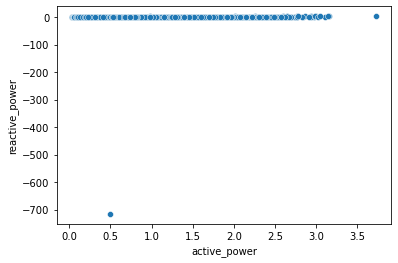

In [23]:
sns.scatterplot(data=data_arc, x='active_power', y='reactive_power')

Мы обнаружили выброс. Но мы не можем просто удалить его, а должны удалить всю партию. 

In [24]:
# Напечатаем партию с выбросом
data_arc[data_arc['key'] == int(data_arc[data_arc['reactive_power'] < 0]['key'])]

,key,start_heat,end_heat,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


In [25]:
# Создадим список с партиями, содержащих выбросы
wrong_keys = data_arc[data_arc['reactive_power'] < 0]['key']
wrong_keys

9780    2116
Name: key, dtype: int64

In [26]:
# Напишем функцию, которая из таблиц будет удалять партии, входящие в wrong_keys
def batches_deleting(wrong_keys, datas_list):
    """Removes from DataFrames strings with keys from wrong_keys

    :param wrong_keys: keys to delete
    :type wrong_keys: Series
    :param datas_list: DataFrames, which need to be cleaned
    :type wrong_keys: list
    """
    for df in datas_list:
        name = [x for x in globals() if globals()[x] is df][0]
        globals()[name] = globals()[name].loc[~globals()[name]['key'].isin(wrong_keys)]

In [27]:
# Вызовем функцию и построим график еще раз
datas_list = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

batches_deleting(wrong_keys, datas_list)

В дальнейшем нужно поступать так же, удалять всю партию из всех датафреймов, если хотя бы один аспект нам не подходит.

<AxesSubplot:xlabel='active_power', ylabel='reactive_power'>

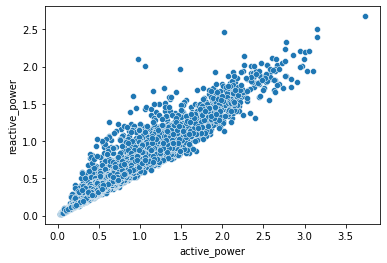

In [28]:
sns.scatterplot(data=data_arc, x='active_power', y='reactive_power')

Присутствует довольно сильная корреляция. Физически процесс нагрева зависит только от активной мощности. Мы можем учесть оба типа если вычислим полную мощность.

Формула полной мощности:  
$$
П = \sqrt{А^2 + Р^2}
$$


Для схлопывания признаков нам полезно выделить не мощность, а работу, т.е. умножить мощность на время. Позже для модели вычислим работу от полной мощности.

<AxesSubplot:xlabel='start_heat', ylabel='end_heat'>

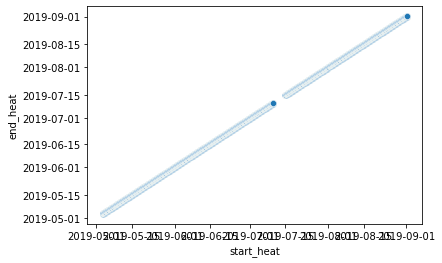

In [29]:
# Проверим даты на наличие выбросов
# Соотвествие начала и конца нагрева можно проверить так
sns.scatterplot(data=data_arc, x='start_heat', y='end_heat')

In [30]:
# Чтобы проверить остальные таблицы на наличие выбросов, применим метод describe()
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3128.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,575.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2805.000000,2248.000000
mean,1624.226343,39.242063,253.045455,113.879045,104.394477,107.025974,118.893913,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.274866,160.513345
std,933.445456,18.277654,21.180578,75.483494,48.184126,81.790646,72.116564,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.878317,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,815.750000,27.000000,242.000000,58.000000,72.000000,70.000000,69.500000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1621.500000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.250000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,206.000000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


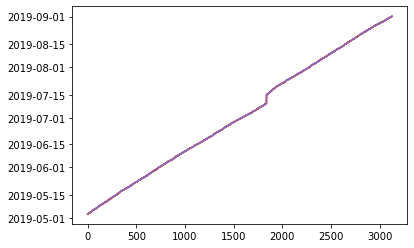

In [31]:
# Временные параметры визуализируем точечным графиком
for coll in data_bulk_time.columns[1:16]:
    data_bulk_time[coll].plot()

In [32]:
data_gas.describe()

,key,gas
count,3238.000000,3238.000000
mean,1621.708771,11.001883
std,935.490478,6.221280
min,1.000000,0.008399
25%,812.250000,7.042678
50%,1621.500000,9.832531
75%,2431.750000,13.770937
max,3241.000000,77.995040


<AxesSubplot:>

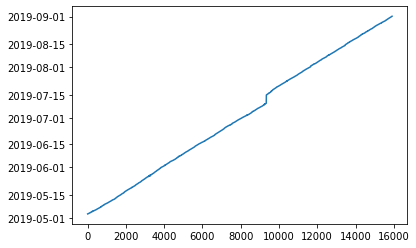

In [33]:
data_temp['measure_time'].plot()

<AxesSubplot:xlabel='key', ylabel='temp'>

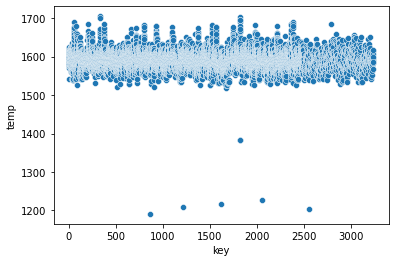

In [34]:
sns.scatterplot(data=data_temp, x='key', y='temp')

Здесь мы видим несколько выбросов. У большинства сортов стали температура плавления около 1500 $C^{\circ}$. И хотя эти выбросы могут быть верными  данными (сталь застыла в ковше), мы имеем право им не доверять и удалить.

In [35]:
wrong_keys = data_temp[data_temp['temp'] < 1450]['key']
wrong_keys

4350      867
5978     1214
7958     1619
8913     1818
8914     1818
10127    2052
12564    2561
Name: key, dtype: int64

<AxesSubplot:xlabel='key', ylabel='temp'>

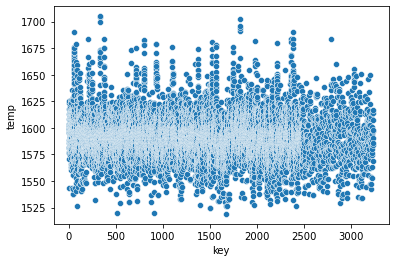

In [36]:
# Вызовем функцию batches_deleting и построим график еще раз
datas_list = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

batches_deleting(wrong_keys, datas_list)

sns.scatterplot(data=data_temp, x='key', y='temp')

Также в этой таблице есть пустые значения температуры. Нам не нужны такие строки, удалим их.

In [37]:
data_temp = data_temp.dropna(subset=['temp'])

data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12957 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           12957 non-null  int64         
 1   measure_time  12957 non-null  datetime64[ns]
 2   temp          12957 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 404.9 KB


In [38]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3075.000000,3049.000000,1077.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.202602,100.857538,50.596728,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,933.550524,42.001374,39.353556,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,821.500000,72.115684,20.180161,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1618.000000,100.152000,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.500000,126.060479,70.242637,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


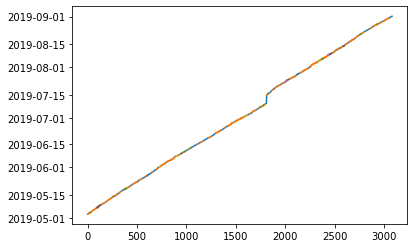

In [39]:
# Временные параметры визуализируем точечным графиком
for coll in data_wire_time.columns[1:11]:
    data_wire_time[coll].plot()

Посмотрим на количество уникальных номеров партии в наборах данных

In [40]:
datas_list = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

for df in datas_list:
    name = [x for x in globals() if globals()[x] is df][0]
    print('Уникальных номеров партии в таблице {0}:'.format(name), len(df['key'].unique()))

Уникальных номеров партии в таблице data_arc: 3207
Уникальных номеров партии в таблице data_bulk: 3123
Уникальных номеров партии в таблице data_bulk_time: 3123
Уникальных номеров партии в таблице data_gas: 3232
Уникальных номеров партии в таблице data_temp: 3209
Уникальных номеров партии в таблице data_wire: 3075
Уникальных номеров партии в таблице data_wire_time: 3075


В разных наборах данных разное количество партий. Некоторые партии остались без той или иной информации. Самое важное - чтобы была разметка тепературы, нагрева и газа (это информация из будущего, окажется, что нет всего 2 строк без разметки газа, удалим их) удалим строки с партиями, которых нет во всех трех таблицах.

In [41]:
# Получим список общих партий из 'data_temp', 'data_gas' и 'data_arc'
keys_list = list(set(data_temp['key'].unique()).intersection(data_gas['key'].unique()).intersection(data_arc['key'].unique()))

In [42]:
# Удалим из остальных данных строки с партиями, которых нет в keys_list
datas_list = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

for df in datas_list:
    name = [x for x in globals() if globals()[x] is df][0]
    globals()[name] = df.loc[df['key'].isin(keys_list)]

In [43]:
# Снова посмотрим на количество уникальных номеров партии в наборах данных
datas_list = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

for df in datas_list:
    name = [x for x in globals() if globals()[x] is df][0]
    print('Уникальных номеров партии в таблице {0}:'.format(name), len(df['key'].unique()))

Уникальных номеров партии в таблице data_arc: 3205
Уникальных номеров партии в таблице data_bulk: 3120
Уникальных номеров партии в таблице data_bulk_time: 3120
Уникальных номеров партии в таблице data_gas: 3205
Уникальных номеров партии в таблице data_temp: 3205
Уникальных номеров партии в таблице data_wire: 3072
Уникальных номеров партии в таблице data_wire_time: 3072


### Создание признаков

Приступим к созданию таблицы, которая в одной строке будет содержаль всю нужную информацию о партии.

Из таблицы *data_temp* нам нужно получить первую и последнюю температуру в каждой партии и время их измерения. Сначала получим пары время-температура в отдельных таблицах, затем объединим их.

In [44]:
# Таблица с первым измерением партии
data_temp_first = data_temp.sort_values(by=['key', 'measure_time']).groupby('key', as_index=False).first()

data_temp_first.rename(columns={'measure_time': 'first_measure', 'temp': 'first_temp'}, inplace=True)

data_temp_first

,key,first_measure,first_temp
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0
...,...,...,...
3200,3237,2019-08-31 22:44:04,1569.0
3201,3238,2019-08-31 23:30:31,1584.0
3202,3239,2019-09-01 01:31:47,1598.0
3203,3240,2019-09-01 02:39:01,1617.0


In [45]:
# Таблица с последним измерением партии
data_temp_last = data_temp.sort_values(by=['key', 'measure_time']).groupby('key', as_index=False).last()

data_temp_last.rename(columns={'measure_time': 'last_measure', 'temp': 'last_temp'}, inplace=True)

data_temp_last

,key,last_measure,last_temp
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0
...,...,...,...
3200,3237,2019-08-31 22:44:04,1569.0
3201,3238,2019-08-31 23:30:31,1584.0
3202,3239,2019-09-01 01:31:47,1598.0
3203,3240,2019-09-01 02:39:01,1617.0


In [46]:
# Объединим полученные таблицы
data_temp_grouped = data_temp_first.merge(data_temp_last, on=['key'])

# Добавим разницу между первым и последним измерением температуры в секундах
data_temp_grouped['measure_time_delta'] = (data_temp_grouped['last_measure']-data_temp_grouped['first_measure']) / np.timedelta64(1, 's')

data_temp_grouped

,key,first_measure,first_temp,last_measure,last_temp,measure_time_delta
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,1305.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,388.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,762.0
...,...,...,...,...,...,...
3200,3237,2019-08-31 22:44:04,1569.0,2019-08-31 22:44:04,1569.0,0.0
3201,3238,2019-08-31 23:30:31,1584.0,2019-08-31 23:30:31,1584.0,0.0
3202,3239,2019-09-01 01:31:47,1598.0,2019-09-01 01:31:47,1598.0,0.0
3203,3240,2019-09-01 02:39:01,1617.0,2019-09-01 02:39:01,1617.0,0.0


<AxesSubplot:xlabel='key', ylabel='measure_time_delta'>

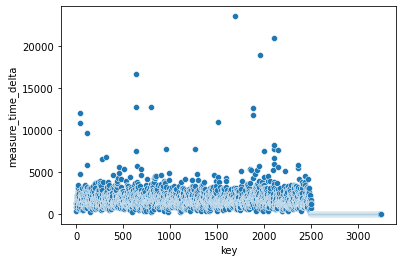

In [47]:
sns.scatterplot(data=data_temp_grouped, x='key', y='measure_time_delta')

У многих партий разница времени либо нулевая, либо слишком большая. Нулевые точно придется удалить, так как если время нулевое, то нечего предсказывать и ничему не обучить, ведь действий с расплавом не успело произойти. Партии со слишком высоким временем тоже лучше удалить.

In [48]:
data_temp_grouped = data_temp_grouped.loc[data_temp_grouped['measure_time_delta'] > 1]
data_temp_grouped = data_temp_grouped.loc[data_temp_grouped['measure_time_delta'] < 10000]

data_temp_grouped

,key,first_measure,first_temp,last_measure,last_temp,measure_time_delta
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,1305.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,388.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,762.0
...,...,...,...,...,...,...
2462,2495,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0,1137.0
2463,2496,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0,1618.0
2464,2497,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0,717.0
2465,2498,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0,1302.0


<AxesSubplot:xlabel='key', ylabel='measure_time_delta'>

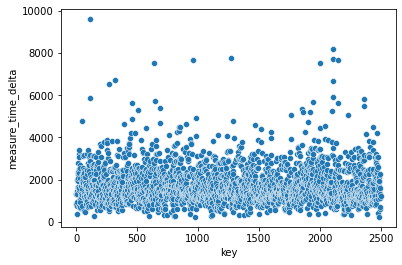

In [49]:
sns.scatterplot(data=data_temp_grouped, x='key', y='measure_time_delta')

Перейдем к таблице *data_arc*. Нам нужна разница между началом и концом нагрева в секундах.


Если нагрев происходил за пределами измерений температуры партии, то такая дельта нам не подходит. Мы будем учитывать только то время, которое было в пределах времени из таблицы *data_temp_grouped*, которую мы получили ранее. 

К сожалению мы ничего не можем сделать, если манипуляции с содержимым ковша произошли слишком близко в измерению температуры и температура еще не успела распределиться.

Добавим в *data_arc* время первого и последнего измерения температуры партии. Оставим только партии, которые есть в таблице *data_temp_grouped*.

In [50]:
data_arc = data_arc.merge(data_temp_grouped[['key', 'first_measure', 'last_measure']], on=['key'], how='right')

data_arc

,key,start_heat,end_heat,active_power,reactive_power,first_measure,last_measure
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,2019-05-03 11:16:18,2019-05-03 11:30:39
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,2019-05-03 11:16:18,2019-05-03 11:30:39
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,2019-05-03 11:16:18,2019-05-03 11:30:39
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,2019-05-03 11:16:18,2019-05-03 11:30:39
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,2019-05-03 11:16:18,2019-05-03 11:30:39
...,...,...,...,...,...,...,...
11283,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,2019-08-06 02:03:49,2019-08-06 02:25:31
11284,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338,2019-08-06 02:40:25,2019-08-06 03:00:28
11285,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,2019-08-06 02:40:25,2019-08-06 03:00:28
11286,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,2019-08-06 02:40:25,2019-08-06 03:00:28


У нас есть шесть возможных вариантов. Просто посчитать разницу между *start_heat* и *end_heat* соответствует только третьему варианту - время нагрева полностью в пределах между *first_measure* и *last_measure*. Нам нужно проверить строки на все варианты и либо полностью обнулить *time_delta*, либо уменьшить до той части, что в нужных пределах.



                      first_measure        last_measure  
                             |--------------------|
        start_heat               
             |-------|   |------|   |-----|  |-------|    |------|
                  end_heat
             1           2          3        4            5
             
                       |--------------------------------|
                       6
                                 Что возможно
       
       
                             |--|   |-----|  |----| 
                             2      3        4
                             
                             |--------------------|
                             6
                              Что нужно получить

In [51]:
def add_delta(start, end, first, last):
    """Calculates the time between start and end, which is in the range between first and last

    :param start: start time before the end, but not tied to first and last
    :type start: datetime
    :param end: end time after the start, but not tied to first and last
    :type end: datetime
    :param first: first time before the end last, but not tied to start and end
    :type first: datetime 
    :param last: last time after the first, but not tied to start and end
    :type last: datetime 
    
    :rtype: float
    :return: the required time in seconds
    """
    if start < first and end < first:
        return 0 # Первый вариант
    
    elif start > last and end > last: 
        return 0 # Пятый вариант
    
    elif start < first and end < last:
        return -(first - end) / np.timedelta64(1, 's') # Второй вариант
    
    elif start > first and end < last:
        return -(start - end) / np.timedelta64(1, 's') # Третий вариант
    
    elif start > first and end > last:
        return -(start - last) / np.timedelta64(1, 's') # Четвертый вариант
    
    elif start < first and end > last:
        return -(first - last) / np.timedelta64(1, 's') # Шестой вариант    


data_arc['time_delta'] = data_arc.apply(
    lambda row: add_delta(row['start_heat'], row['end_heat'], row['first_measure'], row['last_measure']), axis = 1)

data_arc

,key,start_heat,end_heat,active_power,reactive_power,first_measure,last_measure,time_delta
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,2019-05-03 11:16:18,2019-05-03 11:30:39,0.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,2019-05-03 11:16:18,2019-05-03 11:30:39,0.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,2019-05-03 11:16:18,2019-05-03 11:30:39,0.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,2019-05-03 11:16:18,2019-05-03 11:30:39,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,2019-05-03 11:16:18,2019-05-03 11:30:39,148.0
...,...,...,...,...,...,...,...,...
11283,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,2019-08-06 02:03:49,2019-08-06 02:25:31,41.0
11284,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338,2019-08-06 02:40:25,2019-08-06 03:00:28,0.0
11285,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,2019-08-06 02:40:25,2019-08-06 03:00:28,205.0
11286,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,2019-08-06 02:40:25,2019-08-06 03:00:28,295.0


In [52]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11288 entries, 0 to 11287
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             11288 non-null  int64         
 1   start_heat      11288 non-null  datetime64[ns]
 2   end_heat        11288 non-null  datetime64[ns]
 3   active_power    11288 non-null  float64       
 4   reactive_power  11288 non-null  float64       
 5   first_measure   11288 non-null  datetime64[ns]
 6   last_measure    11288 non-null  datetime64[ns]
 7   time_delta      11288 non-null  float64       
dtypes: datetime64[ns](4), float64(3), int64(1)
memory usage: 793.7 KB


In [53]:
# Проверим, нет ли отрицательных результатов в новом столбце
data_arc[data_arc['time_delta'] < 0]

,key,start_heat,end_heat,active_power,reactive_power,first_measure,last_measure,time_delta


<AxesSubplot:xlabel='key', ylabel='time_delta'>

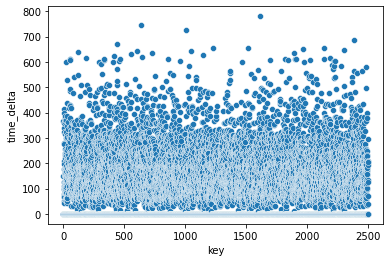

In [54]:
sns.scatterplot(data=data_arc, x='key', y='time_delta')

In [55]:
# Создадим столбцец с работой от полной мощности
def add_full_work(a, r, t):
    """Calculates the multiplication of total capacity and time

    :param a: active power
    :type a: float
    :param r: reactive power
    :type r: float
    :param t: time
    :type t: float
    
    :rtype: float
    :return: multiplication of full capacity and time
    """
    full_capacity = (a**2 + r**2)**0.5
    full_work = full_capacity * t
    
    return full_work

data_arc['full_power_work'] = data_arc.apply(
    lambda row: add_full_work(row['active_power'], row['reactive_power'], row['time_delta']), axis = 1)

# Проверим результат
data_arc

,key,start_heat,end_heat,active_power,reactive_power,first_measure,last_measure,time_delta,full_power_work
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,2019-05-03 11:16:18,2019-05-03 11:30:39,0.0,0.000000
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,2019-05-03 11:16:18,2019-05-03 11:30:39,0.0,0.000000
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,2019-05-03 11:16:18,2019-05-03 11:30:39,0.0,0.000000
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,2019-05-03 11:16:18,2019-05-03 11:30:39,365.0,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,2019-05-03 11:16:18,2019-05-03 11:30:39,148.0,119.471318
...,...,...,...,...,...,...,...,...,...
11283,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,2019-08-06 02:03:49,2019-08-06 02:25:31,41.0,8.788541
11284,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338,2019-08-06 02:40:25,2019-08-06 03:00:28,0.0,0.000000
11285,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,2019-08-06 02:40:25,2019-08-06 03:00:28,205.0,238.313354
11286,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,2019-08-06 02:40:25,2019-08-06 03:00:28,295.0,485.414190


Сгруппируем данные по номеру партии, выведем в полученную таблицу сумму работы электродов.

In [56]:
data_arc_grouped = data_arc.groupby(['key']).agg({'full_power_work':'sum'}).reset_index()

# Проверим результат
data_arc_grouped

,key,full_power_work
0,1,838.692711
1,2,809.781395
2,3,173.239130
3,4,399.037156
4,5,824.212175
...,...,...
2451,2495,546.177193
2452,2496,818.240986
2453,2497,436.894133
2454,2498,401.692006


Аналогично сгруппируем и остальные таблицы, кроме таблиц *data_gas*, *data_bulk_time* и *data_wire_time* - они не нуждаются в группировке.

In [57]:
# Убедимся, что после удаления выбросов у нас не осталось пустых столбцов
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3120 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3120 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1296 non-null   float64
 4   bulk_4   1011 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   573 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2444 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2799 non-null   float64
 15  bulk_15  2242 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 414.4 KB


In [58]:
col_dict = {}
for a in range(1, 16):    
    k = 'bulk_' + str(a)
    col_dict[k] = 'sum'

data_bulk_grouped = data_bulk.groupby(['key']).agg(col_dict).reset_index()


data_bulk_grouped

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3116,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3117,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3118,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


Почти ничего не изменилось, но во всяком случае мы наполнили пропуски нулями и убедились, сгруппировали данные по партиям.

In [59]:
# Убедимся, что после удаления выбросов у нас не осталось пустых столбцов
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3072 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3072 non-null   int64  
 1   wire_1  3046 non-null   float64
 2   wire_2  1077 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 264.0 KB


In [60]:
col_dict = {}
for a in range(1, 10):    
    k = 'wire_' + str(a)
    col_dict[k] = 'sum'

data_wire_grouped = data_wire.groupby(['key']).agg(col_dict).reset_index()


data_wire_grouped

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3067,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3068,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3069,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3070,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Объединим все полученные таблицы

In [61]:
data_full = pd.DataFrame()

In [62]:
datas_list = [data_arc_grouped, data_temp_grouped, data_gas, data_bulk_grouped, data_bulk_time, data_wire_grouped, data_wire_time]

In [63]:
data_full = datas_list[0]

for df in datas_list[1:7]:
    name0 = [x for x in globals() if globals()[x] is df][0]
    name1 = [x for x in globals() if globals()[x] is df][1]
    if name0 != 'df':
        data_full = data_full.merge(globals()[name0], on=['key'], how='left')
    else:
        data_full = data_full.merge(globals()[name1], on=['key'], how='left')

In [64]:
# Сброс ограничений на число отображаемых столбцов
pd.set_option('display.max_columns', None)

# Проверим результат
data_full

,key,full_power_work,first_measure,first_temp,last_measure,last_temp,measure_time_delta,gas,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
0,1,838.692711,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861.0,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,809.781395,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,1305.0,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,173.239130,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300.0,28.554793,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,399.037156,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,388.0,18.841219,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,824.212175,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,762.0,5.413692,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,2495,546.177193,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0,1137.0,7.125735,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,NaT,NaT,2019-08-06 00:49:21,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-06 00:36:47,NaT,2019-08-06 00:32:18,NaT,2019-08-06 00:32:18,2019-08-06 00:32:18,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-06 00:36:13,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2452,2496,818.240986,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0,1618.0,9.412616,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,NaT,NaT,NaT,2019-08-06 01:14:16,NaT,NaT,NaT,NaT,NaT,2019-08-06 01:14:16,NaT,2019-08-06 01:06:37,NaT,2019-08-06 01:06:37,2019-08-06 01:06:37,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-06 01:13:33,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2453,2497,436.894133,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0,717.0,6.271699,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,NaT,NaT,NaT,2019-08-06 01:43:02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-06 01:38:54,NaT,2019-08-06 01:38:54,2019-08-06 01:38:53,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-06 01:42:27,2019-08-06 01:42:51,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2454,2498,401.692006,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0,1302.0,14.953657,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0

In [65]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2456 entries, 0 to 2455
Data columns (total 56 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 2456 non-null   int64         
 1   full_power_work     2456 non-null   float64       
 2   first_measure       2456 non-null   datetime64[ns]
 3   first_temp          2456 non-null   float64       
 4   last_measure        2456 non-null   datetime64[ns]
 5   last_temp           2456 non-null   float64       
 6   measure_time_delta  2456 non-null   float64       
 7   gas                 2456 non-null   float64       
 8   bulk_1              2389 non-null   float64       
 9   bulk_2              2389 non-null   float64       
 10  bulk_3              2389 non-null   float64       
 11  bulk_4              2389 non-null   float64       
 12  bulk_5              2389 non-null   float64       
 13  bulk_6              2389 non-null   float64     

В будущем нам не понадобятся столбцы с временем, но прежде чем удалить их, нужно проверить, что все прочие действия были между первым и последним измерением температуры. Тогда в столбце *first_measure* самое раннее время во всей строке, а в *last_measure* - самое позднее. 

Время продувки газом нам не известно, будем верить, что ее сделали между первым и последним измерением температуры. 

Запомним, что *wire_time_5* пуст, значит *wire_5* можно не включать в итоговый набор данных.

In [66]:
# Заполним пропуски каждой строки датой first_measure + 1 секунда
col_list = ['bulk_time_1', 'bulk_time_2', 'bulk_time_3', 'bulk_time_4', 'bulk_time_5',
    'bulk_time_6', 'bulk_time_7', 'bulk_time_8', 'bulk_time_9', 'bulk_time_10', 'bulk_time_11', 
    'bulk_time_12', 'bulk_time_13', 'bulk_time_14', 'bulk_time_15', 'wire_time_1', 'wire_time_2', 
    'wire_time_3', 'wire_time_4', 'wire_time_6', 'wire_time_6', 'wire_time_7', 'wire_time_8', 'wire_time_9']

for i in range(len(col_list)):
    data_full[col_list[i]] = data_full[col_list[i]].fillna(data_full['first_measure']+datetime.timedelta(seconds=1))

# Заполним остальные пропуски нулями    
data_full = data_full.fillna(0)    

# Проверим результат
data_full

,key,full_power_work,first_measure,first_temp,last_measure,last_temp,measure_time_delta,gas,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
0,1,838.692711,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861.0,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,2019-05-03 11:16:19,2019-05-03 11:16:19,2019-05-03 11:16:19,2019-05-03 11:21:30,2019-05-03 11:16:19,2019-05-03 11:16:19,2019-05-03 11:16:19,2019-05-03 11:16:19,2019-05-03 11:16:19,2019-05-03 11:16:19,2019-05-03 11:16:19,2019-05-03 11:03:52,2019-05-03 11:16:19,2019-05-03 11:03:52,2019-05-03 11:03:52,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:11:41,2019-05-03 11:16:19,2019-05-03 11:16:19,2019-05-03 11:16:19,0,2019-05-03 11:16:19,2019-05-03 11:16:19,2019-05-03 11:16:19,2019-05-03 11:16:19
1,2,809.781395,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,1305.0,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,2019-05-03 11:37:28,2019-05-03 11:37:28,2019-05-03 11:37:28,2019-05-03 11:46:38,2019-05-03 11:37:28,2019-05-03 11:37:28,2019-05-03 11:37:28,2019-05-03 11:37:28,2019-05-03 11:37:28,2019-05-03 11:37:28,2019-05-03 11:37:28,2019-05-03 11:40:20,2019-05-03 11:37:28,2019-05-03 11:40:20,2019-05-03 11:40:20,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:46:10,2019-05-03 11:37:28,2019-05-03 11:37:28,2019-05-03 11:37:28,0,2019-05-03 11:37:28,2019-05-03 11:37:28,2019-05-03 11:37:28,2019-05-03 11:37:28
2,3,173.239130,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300.0,28.554793,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,2019-05-03 12:13:18,2019-05-03 12:13:18,2019-05-03 12:13:18,2019-05-03 12:31:06,2019-05-03 12:13:18,2019-05-03 12:13:18,2019-05-03 12:13:18,2019-05-03 12:13:18,2019-05-03 12:13:18,2019-05-03 12:13:18,2019-05-03 12:13:18,2019-05-03 12:09:40,2019-05-03 12:13:18,2019-05-03 12:09:40,2019-05-03 12:09:40,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:13:47,2019-05-03 12:13:18,2019-05-03 12:13:18,2019-05-03 12:13:18,0,2019-05-03 12:13:18,2019-05-03 12:13:18,2019-05-03 12:13:18,2019-05-03 12:13:18
3,4,399.037156,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,388.0,18.841219,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,2019-05-03 12:52:58,2019-05-03 12:52:58,2019-05-03 12:52:58,2019-05-03 12:48:43,2019-05-03 12:52:58,2019-05-03 12:52:58,2019-05-03 12:52:58,2019-05-03 12:52:58,2019-05-03 12:52:58,2019-05-03 12:52:58,2019-05-03 12:52:58,2019-05-03 12:41:24,2019-05-03 12:52:58,2019-05-03 12:41:24,2019-05-03 12:41:24,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:48:05,2019-05-03 12:52:58,2019-05-03 12:52:58,2019-05-03 12:52:58,0,2019-05-03 12:52:58,2019-05-03 12:52:58,2019-05-03 12:52:58,2019-05-03 12:52:58
4,5,824.212175,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,762.0,5.413692,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,2019-05-03 13:23:20,2019-05-03 13:23:20,2019-05-03 13:23:20,2019-05-03 13:18:50,2019-05-03 13:23:20,2019-05-03 13:23:20,2019-05-03 13:23:20,2019-05-03 13:23:20,2019-05-03 13:23:20,2019-05-03 13:23:20,2019-05-03 13:23:20,2019-05-03 13:12:56,2019-05-03 13:23:20,2019-05-03 13:12:56,2019-05-03 13:12:56,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:18:15,2019-05-03 13:32:06,2019-05-03 13:23:20,2019-05-03 13:23:20,0,2019-05-03 13:23:20,2019-05-03 13:23:20,2019-05-03 13:23:20,2019-05-03 13:23:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [67]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2456 entries, 0 to 2455
Data columns (total 56 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 2456 non-null   int64         
 1   full_power_work     2456 non-null   float64       
 2   first_measure       2456 non-null   datetime64[ns]
 3   first_temp          2456 non-null   float64       
 4   last_measure        2456 non-null   datetime64[ns]
 5   last_temp           2456 non-null   float64       
 6   measure_time_delta  2456 non-null   float64       
 7   gas                 2456 non-null   float64       
 8   bulk_1              2456 non-null   float64       
 9   bulk_2              2456 non-null   float64       
 10  bulk_3              2456 non-null   float64       
 11  bulk_4              2456 non-null   float64       
 12  bulk_5              2456 non-null   float64       
 13  bulk_6              2456 non-null   float64     

Очистим партии от действий, которые происходили за пределами измерения температуры.

In [68]:
clean_data_full = data_full.copy()

In [69]:
# Проверка действий bulk_n
def bulk_1_check(seq):
    if (seq.loc['first_measure'] > seq.loc['bulk_time_1']) | (seq.loc['last_measure'] < seq.loc['bulk_time_1']):
        return 0
    else:
        return seq.loc['bulk_1']
    
def bulk_2_check(seq):
    if (seq.loc['first_measure'] > seq.loc['bulk_time_2']) | (seq.loc['last_measure'] < seq.loc['bulk_time_2']):
        return 0
    else:
        return seq.loc['bulk_2']
    
def bulk_3_check(seq):
    if (seq.loc['first_measure'] > seq.loc['bulk_time_3']) | (seq.loc['last_measure'] < seq.loc['bulk_time_3']):
        return 0
    else:
        return seq.loc['bulk_3']
    
def bulk_4_check(seq):
    if (seq.loc['first_measure'] > seq.loc['bulk_time_4']) | (seq.loc['last_measure'] < seq.loc['bulk_time_4']):
        return 0
    else:
        return seq.loc['bulk_4']

def bulk_5_check(seq):
    if (seq.loc['first_measure'] > seq.loc['bulk_time_5']) | (seq.loc['last_measure'] < seq.loc['bulk_time_5']):
        return 0
    else:
        return seq.loc['bulk_5']
    
def bulk_6_check(seq):
    if (seq.loc['first_measure'] > seq.loc['bulk_time_6']) | (seq.loc['last_measure'] < seq.loc['bulk_time_6']):
        return 0
    else:
        return seq.loc['bulk_6']
    
def bulk_7_check(seq):
    if (seq.loc['first_measure'] > seq.loc['bulk_time_7']) | (seq.loc['last_measure'] < seq.loc['bulk_time_7']):
        return 0
    else:
        return seq.loc['bulk_7']
    
def bulk_8_check(seq):
    if (seq.loc['first_measure'] > seq.loc['bulk_time_8']) | (seq.loc['last_measure'] < seq.loc['bulk_time_8']):
        return 0
    else:
        return seq.loc['bulk_8']
    
def bulk_9_check(seq):
    if (seq.loc['first_measure'] > seq.loc['bulk_time_9']) | (seq.loc['last_measure'] < seq.loc['bulk_time_9']):
        return 0
    else:
        return seq.loc['bulk_9']
    
def bulk_10_check(seq):
    if (seq.loc['first_measure'] > seq.loc['bulk_time_10']) | (seq.loc['last_measure'] < seq.loc['bulk_time_10']):
        return 0
    else:
        return seq.loc['bulk_10']
    
def bulk_11_check(seq):
    if (seq.loc['first_measure'] > seq.loc['bulk_time_11']) | (seq.loc['last_measure'] < seq.loc['bulk_time_11']):
        return 0
    else:
        return seq.loc['bulk_11']
    
def bulk_12_check(seq):
    if (seq.loc['first_measure'] > seq.loc['bulk_time_12']) | (seq.loc['last_measure'] < seq.loc['bulk_time_12']):
        return 0
    else:
        return seq.loc['bulk_12']
    
def bulk_13_check(seq):
    if (seq.loc['first_measure'] > seq.loc['bulk_time_13']) | (seq.loc['last_measure'] < seq.loc['bulk_time_13']):
        return 0
    else:
        return seq.loc['bulk_13']
    
def bulk_14_check(seq):
    if (seq.loc['first_measure'] > seq.loc['bulk_time_14']) | (seq.loc['last_measure'] < seq.loc['bulk_time_14']):
        return 0
    else:
        return seq.loc['bulk_14']
    
def bulk_15_check(seq):
    if (seq.loc['first_measure'] > seq.loc['bulk_time_15']) | (seq.loc['last_measure'] < seq.loc['bulk_time_15']):
        return 0
    else:
        return seq.loc['bulk_15']
    
# Проверка действий wire_n    
def wire_1_check(seq):
    if (seq.loc['first_measure'] > seq.loc['wire_time_1']) | (seq.loc['last_measure'] < seq.loc['wire_time_1']):
        return 0
    else:
        return seq.loc['wire_1']
    
def wire_2_check(seq):
    if (seq.loc['first_measure'] > seq.loc['wire_time_2']) | (seq.loc['last_measure'] < seq.loc['wire_time_2']):
        return 0
    else:
        return seq.loc['wire_2']
    
def wire_3_check(seq):
    if (seq.loc['first_measure'] > seq.loc['wire_time_3']) | (seq.loc['last_measure'] < seq.loc['wire_time_3']):
        return 0
    else:
        return seq.loc['wire_3']
    
def wire_4_check(seq):
    if (seq.loc['first_measure'] > seq.loc['wire_time_4']) | (seq.loc['last_measure'] < seq.loc['wire_time_4']):
        return 0
    else:
        return seq.loc['wire_4']
    
#def wire_5_check(seq):
    #if (seq.loc['first_measure'] > seq.loc['wire_time_5']) | (seq.loc['last_measure'] < seq.loc['wire_time_5']):
        #return 0
    #else:
        #return seq.loc['wire_5']
    
def wire_6_check(seq):
    if (seq.loc['first_measure'] > seq.loc['wire_time_6']) | (seq.loc['last_measure'] < seq.loc['wire_time_6']):
        return 0
    else:
        return seq.loc['wire_6']
    
def wire_7_check(seq):
    if (seq.loc['first_measure'] > seq.loc['wire_time_7']) | (seq.loc['last_measure'] < seq.loc['wire_time_8']):
        return 0
    else:
        return seq.loc['wire_7']
    
def wire_8_check(seq):
    if (seq.loc['first_measure'] > seq.loc['wire_time_8']) | (seq.loc['last_measure'] < seq.loc['wire_time_8']):
        return 0
    else:
        return seq.loc['wire_8']
    
def wire_9_check(seq):
    if (seq.loc['first_measure'] > seq.loc['wire_time_9']) | (seq.loc['last_measure'] < seq.loc['wire_time_9']):
        return 0
    else:
        return seq.loc['wire_9']

In [70]:
# Вызов функций bulk_n
clean_data_full['bulk_1'] = clean_data_full.apply(bulk_1_check, axis=1)

clean_data_full['bulk_2'] = clean_data_full.apply(bulk_2_check, axis=1)

clean_data_full['bulk_3'] = clean_data_full.apply(bulk_3_check, axis=1)

clean_data_full['bulk_4'] = clean_data_full.apply(bulk_4_check, axis=1)

clean_data_full['bulk_5'] = clean_data_full.apply(bulk_5_check, axis=1)

clean_data_full['bulk_6'] = clean_data_full.apply(bulk_6_check, axis=1)

clean_data_full['bulk_7'] = clean_data_full.apply(bulk_7_check, axis=1)

clean_data_full['bulk_8'] = clean_data_full.apply(bulk_8_check, axis=1)

clean_data_full['bulk_9'] = clean_data_full.apply(bulk_9_check, axis=1)

clean_data_full['bulk_10'] = clean_data_full.apply(bulk_10_check, axis=1)

clean_data_full['bulk_11'] = clean_data_full.apply(bulk_11_check, axis=1)

clean_data_full['bulk_12'] = clean_data_full.apply(bulk_12_check, axis=1)

clean_data_full['bulk_13'] = clean_data_full.apply(bulk_13_check, axis=1)

clean_data_full['bulk_14'] = clean_data_full.apply(bulk_14_check, axis=1)

clean_data_full['bulk_15'] = clean_data_full.apply(bulk_15_check, axis=1)

# Вызов функций wire_n
clean_data_full['wire_1'] = clean_data_full.apply(wire_1_check, axis=1)

clean_data_full['wire_2'] = clean_data_full.apply(wire_2_check, axis=1)

clean_data_full['wire_3'] = clean_data_full.apply(wire_3_check, axis=1)

clean_data_full['wire_4'] = clean_data_full.apply(wire_4_check, axis=1)

#clean_data_full['wire_5'] = clean_data_full.apply(wire_5_check, axis=1)

clean_data_full['wire_6'] = clean_data_full.apply(wire_6_check, axis=1)

clean_data_full['wire_7'] = clean_data_full.apply(wire_7_check, axis=1)

clean_data_full['wire_8'] = clean_data_full.apply(wire_8_check, axis=1)

clean_data_full['wire_9'] = clean_data_full.apply(wire_9_check, axis=1)

In [71]:
clean_data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2456 entries, 0 to 2455
Data columns (total 56 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 2456 non-null   int64         
 1   full_power_work     2456 non-null   float64       
 2   first_measure       2456 non-null   datetime64[ns]
 3   first_temp          2456 non-null   float64       
 4   last_measure        2456 non-null   datetime64[ns]
 5   last_temp           2456 non-null   float64       
 6   measure_time_delta  2456 non-null   float64       
 7   gas                 2456 non-null   float64       
 8   bulk_1              2456 non-null   float64       
 9   bulk_2              2456 non-null   float64       
 10  bulk_3              2456 non-null   float64       
 11  bulk_4              2456 non-null   float64       
 12  bulk_5              2456 non-null   float64       
 13  bulk_6              2456 non-null   float64     

Изучим мулькорреляцию полученного набора данных. Лучше всего визуализировать коррекцию в виде тепловой карты.

In [72]:
corrmat = clean_data_full.corr()
corrmat

,key,full_power_work,first_temp,last_temp,measure_time_delta,gas,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_5
key,1.000000,-0.013601,-0.014481,-0.080090,-0.007279,-0.044105,-0.073452,-0.012666,-0.002312,-0.017412,0.031561,0.013272,0.045809,0.015008,-0.038322,0.060194,0.031469,0.019028,-0.020507,-0.062866,-0.053196,0.017928,0.046997,-0.027698,0.047109,NaN,-0.021576,0.033456,-0.034725,0.033409,NaN
full_power_work,-0.013601,1.000000,-0.347665,0.305195,0.437367,0.285085,0.088491,-0.002150,0.084699,-0.027708,-0.021629,0.099598,0.016787,-0.005674,-0.006117,0.003526,0.063751,0.497960,-0.008490,0.436413,0.335958,0.030486,0.013242,-0.001025,-0.011339,NaN,0.021673,-0.001756,-0.002922,-0.020409,NaN
first_temp,-0.014481,-0.347665,1.000000,0.441976,0.180727,-0.010920,0.071865,0.119003,-0.124340,0.122847,0.062517,-0.136822,0.065736,-0.012077,-0.035121,0.023844,-0.111515,0.054971,0.009369,0.004698,0.008081,0.163923,-0.090656,-0.012438,0.046819,NaN,0.013095,0.042580,-0.031796,0.006896,NaN
last_temp,-0.080090,0.305195,0.441976,1.000000,0.025768,-0.024928,-0.070488,-0.049080,-0.080966,0.047061,-0.026808,-0.171718,-0.062681,-0.020711,-0.019658,0.013420,-0.096782,0.164608,-0.031487,0.047609,0.021793,-0.044718,-0.189068,-0.041295,-0.099780,NaN,-0.058783,-0.090918,-0.015927,-0.039308,NaN
measure_time_delta,-0.007279,0.437367,0.180727,0.025768,1.000000,0.496312,0.219144,0.254598,0.094696,0.071284,0.113793,0.138566,0.217916,-0.004255,-0.012584,0.034044,0.025666,0.389940,0.054760,0.391019,0.357296,0.328613,0.103965,0.101214,0.200338,NaN,0.155629,0.187451,-0.007162,0.021535,NaN
gas,-0.044105,0.285085,-0.010920,-0.024928,0.496312,1.000000,0.240720,0.198799,0.086836,0.050279,0.082155,0.133651,0.173830,0.005117,0.120210,0.006355,0.041594,0.239804,0.003947,0.253117,0.125762,0.135525,0.104340,0.098606,0.099937,NaN,0.105490,0.069053,0.121667,0.007875,NaN
bulk_1,-0.073452,0.088491,0.071865,-0.070488,0.219144,0.240720,1.000000,0.217503,0.002647,0.049247,0.059654,0.004652,0.227631,-0.005036,-0.017377,-0.013112,-0.028548,0.350653,-0.002127,0.245838,0.078410,0.075553,0.010665,0.020362,0.106727,NaN,0.157241,0.077653,-0.017183,0.007141,NaN
bulk_2,-0.012666,-0.002150,0.119003,-0.049080,0.254598,0.198799,0.217503,1.000000,-0.041196,0.041090,0.352161,-0.026009,0.650153,-0.001407,-0.004855,-0.016015,0.004480,-0.069343,-0.004350,-0.088348,-0.070578,-0.114954,-0.034411,0.217758,0.634895,NaN,0.581897,0.421094,-0.004801,-0.006436,NaN
bulk_3,-0.002312,0.084699,-0.124340,-0.080966,0.094696,0.086836,0.002647,-0.041196,1.000000,-0.252062,0.001740,0.072266,-0.027858,0.022284,0.009778,-0.066017,0.001188,0.061555,0.005319,0.068130,0.062816,0.098518,0.118293,0.010828,-0.033779,NaN,-0.004314,-0.016622,0.003577,-0.004455,NaN
bulk_4,-0.017412,-0.027708,0.122847,0.047061,0.071284,0.050279,0.049247,0.041090,-0.252062,1.000000,0.034589,-0.215100,0.044702,-0.012038,0.001391,-0.065100,-0.104572,0.124184,0.020395,-0.006964,0.135745,0.317065,-0.234691,-0.034202,0.030568,NaN,-0.004241,0.033761,0.012204,-0.054863,NaN


<AxesSubplot:>

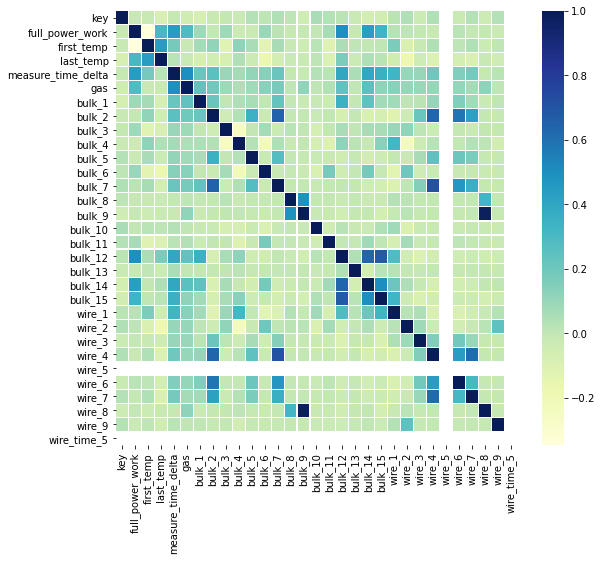

In [73]:
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

Столбец *wire_5* полностью заполнен нулями, поэтому корреляция нулевая. Есть единичные темные пятна, но в основном это различные bulk_n и wire_n. Из первых шести столбцов больше всего коррелируют gas и measure_time_delta со значением 0.496. Эта зависимость может быль нормальной частью техпроцесса.

In [74]:
# Отделим целевой признак от прочих признаков
target = clean_data_full['last_temp']

features = clean_data_full[['full_power_work', 'measure_time_delta', 'first_temp', 'gas', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 
    'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 
    'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8', 'wire_9']]

In [75]:
# Разделим данные признаков на выборки с помощью функции train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            train_size=0.6, 
                                                                            random_state=SEED)

# Проверим результат
print("Длина тренировочной выборки:", len(features_train))
print("Длина тестовой выборки:", len(features_test))
print("Сумма признаков:", len(features_train) + len(features_test))
print()
print("Длина тренировочной выборки:", len(target_train))
print("Длина тестовой выборки:", len(target_test))
print("Сумма целевых признаков:", len(target_train) + len(target_test))

Длина тренировочной выборки: 1473
Длина тестовой выборки: 983
Сумма признаков: 2456

Длина тренировочной выборки: 1473
Длина тестовой выборки: 983
Сумма целевых признаков: 2456


## Обучение моделей

Приступим к обучению и проверке моделей. Начнем с логистической регрессии. Затем к остальным моделям, гиперпараметры которых подберем пайплайнами.

In [76]:
model = LinearRegression()
model.fit(features_train, target_train)

# Получим предсказания модели
predicted_test = pd.Series(model.predict(features_test))
predicted_test.index = target_test.index

In [77]:
print('Итоговое MAE логистической регрессии: {:.2f}'.format(mean_absolute_error(target_test, predicted_test)))

Итоговое MAE логистической регрессии: 7.08


In [78]:
# С помощью Pipeline и GridSearchCV найдем лучшие параметры для модели DecisionTreeRegressor
cv_n = 5

pipe_DTRegressor = Pipeline([('scaler',  StandardScaler()),
            ('DTRegressor', DecisionTreeRegressor(random_state=SEED))])

grid_params_DTRegressor = [{'DTRegressor__max_depth': range (1, 13, 2),
                            'DTRegressor__min_samples_leaf': range (1, 8),
                            'DTRegressor__min_samples_split': range (2, 10, 2)
                          }]

CV_dtregressor = GridSearchCV (estimator = pipe_DTRegressor,
                               param_grid = grid_params_DTRegressor,
                               cv = cv_n,
                               scoring = 'neg_mean_absolute_error', verbose=0, return_train_score=True)

CV_dtregressor.fit(features_train, target_train)

dtr_best_params = CV_dtregressor.best_params_
dtr_best_model = CV_dtregressor.best_estimator_
dtr_score = CV_dtregressor.best_score_

In [79]:
# Вычислим MAE модели к тестовой выборке
dtr_predictions_test = dtr_best_model.predict(features_test)
print('Итоговое MAE дерева решений: {:.2f}'.format(mean_absolute_error(target_test, dtr_predictions_test)))

Итоговое MAE дерева решений: 7.25


In [80]:
# Для RandomForestRegressor используем Pipeline и GridSearchCV
pipe_RFRegressor = Pipeline([('scaler',  StandardScaler()),
            ('RFRegressor', RandomForestRegressor(random_state=SEED))])

grid_params_RFRegressor = [{'RFRegressor__n_estimators': range (5, 50, 5),
                            'RFRegressor__max_depth': range (1, 21, 2)
                           }]

CV_rfregressor = GridSearchCV (estimator = pipe_RFRegressor,
                               param_grid = grid_params_RFRegressor,
                               cv = cv_n,
                               scoring = 'neg_mean_absolute_error', verbose=0, return_train_score=True)

CV_rfregressor.fit(features_train, target_train)

dfr_best_params = CV_rfregressor.best_params_
dfr_best_model = CV_rfregressor.best_estimator_
dfr_score = CV_rfregressor.best_score_

In [81]:
# Вычислим MAE модели к тестовой выборке
dfr_grid_predictions = dfr_best_model.predict(features_test)
print('Итоговое MAE дерева решений: {:.2f}'.format(mean_absolute_error(target_test, dfr_grid_predictions)))

Итоговое MAE дерева решений: 6.12


In [82]:
# Для LGBMRegressor используем Pipeline и GridSearchCV
pipe_LGBMRegressor = Pipeline([('scaler',  StandardScaler()),
            ('LGBMRegressor', LGBMRegressor(random_state=SEED))])

grid_params_LGBMRegressor = [{'LGBMRegressor__n_estimators': range (30, 80, 10),
                            'LGBMRegressor__max_depth': range (1, 13, 2),
                            'LGBMRegressor__learning_rate': [0.1, 1.0]
                             }]

CV_lgbmregressor = GridSearchCV (estimator = pipe_LGBMRegressor,
                               param_grid = grid_params_LGBMRegressor,
                               cv = cv_n,
                               scoring = 'neg_mean_absolute_error', verbose=0, return_train_score=True)

CV_lgbmregressor.fit(features_train, target_train)

lgbmr_best_params = CV_lgbmregressor.best_params_
lgbmr_best_model = CV_lgbmregressor.best_estimator_
lgbmr_score = CV_lgbmregressor.best_score_

In [83]:
# Вычислим MAE модели к тестовой выборке
lgbmr_grid_predictions = lgbmr_best_model.predict(features_test)
print('Итоговое MAE дерева решений: {:.2f}'.format(mean_absolute_error(target_test, lgbmr_grid_predictions)))

Итоговое MAE дерева решений: 6.07


In [84]:
# С помощью Pipeline и GridSearchCV найдем лучшие параметры для модели KNeighborsRegressor


pipe_KNRegressor = Pipeline([('scaler',  StandardScaler()),
            ('KNRegressor', KNeighborsRegressor())])

grid_params_KNRegressor = [{'KNRegressor__n_neighbors': range (3, 11, 2),
                    'KNRegressor__weights': ('uniform', 'distance'),
                    'KNRegressor__algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute')
}]

CV_knregressor = GridSearchCV (estimator = pipe_KNRegressor,
                               param_grid = grid_params_KNRegressor,
                               cv = cv_n,
                               scoring = 'neg_mean_absolute_error', verbose=0, return_train_score=True)

CV_knregressor.fit(features_train, target_train)

knr_best_params = CV_knregressor.best_params_
knr_best_model = CV_knregressor.best_estimator_
knr_score = CV_knregressor.best_score_

In [85]:
# Вычислим sMAPE модели к тестовой выборке
knr_predictions_valid = knr_best_model.predict(features_test)
print('Итоговое MAE метода ближайших соседей: {:.2f}'.format(mean_absolute_error(target_test, knr_predictions_valid)))

Итоговое MAE метода ближайших соседей: 6.95


## Выводы

Лучшие результаты показали модель случайный лес и модель градиентного бустинга с абсолютной ошибкой около 6,12 и 6,07 градусов цельсия соответственно. Посмотрим, какие признаки для них оказались самыми важными.

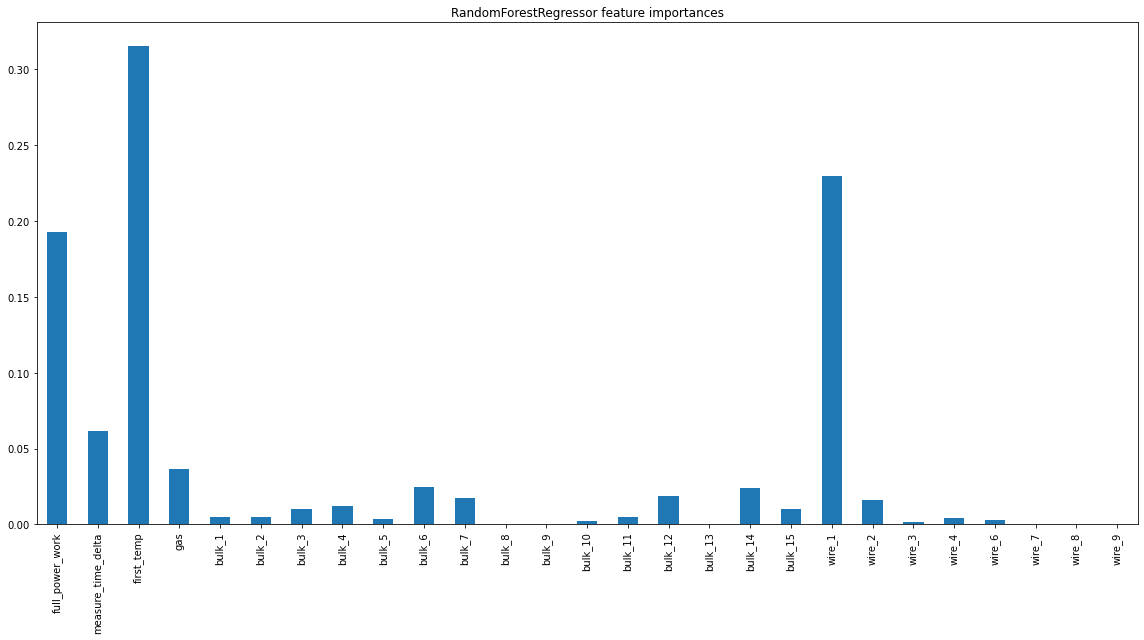

In [86]:
feature_names = features.columns

importances = CV_rfregressor.best_estimator_.named_steps["RFRegressor"].feature_importances_


forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(16,9))
forest_importances.plot.bar(ax=ax)
ax.set_title("RandomForestRegressor feature importances")
fig.tight_layout()

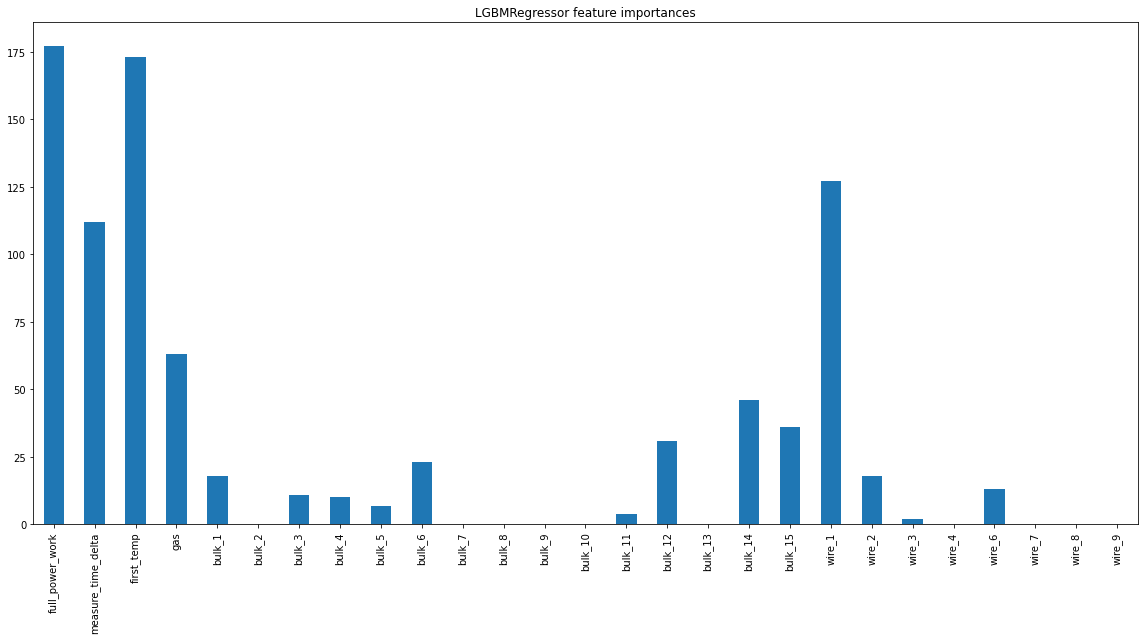

In [87]:
feature_names = features.columns

importances = CV_lgbmregressor.best_estimator_.named_steps["LGBMRegressor"].feature_importances_


lgbm_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(16,9))
lgbm_importances.plot.bar(ax=ax)
ax.set_title("LGBMRegressor feature importances")
fig.tight_layout()

Градация важности признаков у моделей разная, но есть и пересечения. Очень важный признак работы нагрева электродами и первой измеренной температуры. Неожиданно важен и параметр wire_1, видимо этот пруток добавляют часто и в больших количествах. Остальные параметры модель случайного леса не пометила большой важностью, а модель градиентного бустинга обращает большое внимание на время между измерением первой и целевой температур.

Нашей целью является снижение энергозатрат предприятия при производстве стали. Следовательно, теперь мы можем тратить на нагрев ровно столько энергии, сколько необходимо для получения целевой, оптимальной температуры. Первая температура тоже очень важна, если мы можем ею управлять.

Остается проблема разброса параметров, ошибки при предсказании. Может быть дело в несовершенстве модели и в отмеченных ранее недостатке информаци и недостаточном времени на распределение температуры. Но колебания температуры независимо от прочих показателей существуют всегда, этому способствуют тысячи независимых фаторов. И работа над их стабилизацией, над разбросом факторов, это следующий этап над повышением энергоэффективности технологического процесса. 

Пытаясь уменьшить разброс в измерениях опираясь над модель - возможно, можно быдет выявить эти факторы и повысить эффективность. Здесь нет мелочей, химия газов и прутков, номер бригады, смена деталей оборудования и температура в цехе, любой параметр может оказать существенное влияние и помочь сэкономить много энергии, и следовательно, денег.